# March Data Labs - Profiles Group v2 - Development Version
*OOI Data Labs Workshop - March 2019*

Notebook Revised 10/1/2019 by Sage

**Key Goals**
* Students will look at how different parameters are related to photosynthesis, including an “ideal profile” with an Oxygen minimum zone
* Also want students to look at seasonal changes, for eample how do DO and Chl co-vary seasonally? 

**Data Needs**
* Extract monthly 1-2 day samples from 1 year at the Axial profiler (RS03)
* Allow students to plot 2 variables at a time for a given month
* Needed variables: Temp, Salinity, DO, Chlorophyll, pCO2.  Maybe also Nitrate and PAR.
* Potentially show variablilty of multiple profiles (i.e. raw data from 1-2 days) as well as a "clean" profile (averaged) to show the general structure.

**Can we also show deep structure?**
* Unfortunatley, we don't have full profiles in deep locations.  We would need to stich together the one 6-month GI Glider and dataset with the Profiler.
* We could leave a gap at surface to have student guess why data is missing.
* Probably need to exclude data below 1,200m to avoid shwoing confusing features

In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
! pip install netcdf4==1.5.0

# Setup default plot styles
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

     |████████████████████████████████| 3.9MB 2.7MB/s 
     |████████████████████████████████| 307kB 39.3MB/s 


## Request Data

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL upon success, else return error message
  if 'allURLs' in data.keys():
    return data['allURLs'][0]
  else:
    print('Request Error')
    print(data['message']['status'])
    return data


In [0]:
# Data Requests
# request_data('GI05MOAS-PG528-01-CTDGVM000','recovered_host','ctdgv_m_glider_instrument_recovered','','')
# request_data('GI05MOAS-PG528-02-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered','','')
# request_data('GI05MOAS-PG528-03-FLORTM000','recovered_host','flort_m_sample','','')

## Load Glider Datasets

In [0]:
# Glider for testing
gl528_ctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152234-GI05MOAS-PG528-01-CTDGVM000-recovered_host-ctdgv_m_glider_instrument_recovered/catalog.html'
gl528_do_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152634-GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
gl528_flo_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190509T152241-GI05MOAS-PG528-03-FLORTM000-recovered_host-flort_m_sample/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    elif '_cal_' in d: #Remove pco2 cal streams
      pass
    else:
      selected_datasets.append(d)
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets) #,data_vars=['seawater_temperature','practical_salinity','corrected_dissolved_oxygen'])
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  # ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds
  

In [0]:
%%time
ctd_data = get_data(gl528_do_url,'ctdgv')

CPU times: user 252 ms, sys: 105 ms, total: 357 ms
Wall time: 26.5 s


In [0]:
%%time
flo_data = get_data(gl528_flo_url,'ctdgv')

CPU times: user 372 ms, sys: 101 ms, total: 474 ms
Wall time: 31.1 s


## Binning Data
First let's figure out how we can bin data in space and time.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


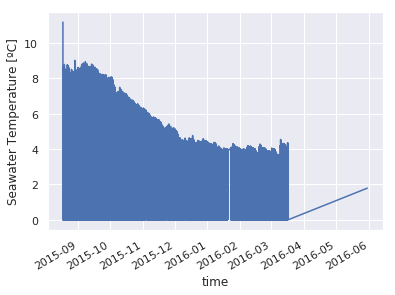

In [0]:
# Here's what the raw temp data looks like
ctd_data.sci_water_temp.plot();

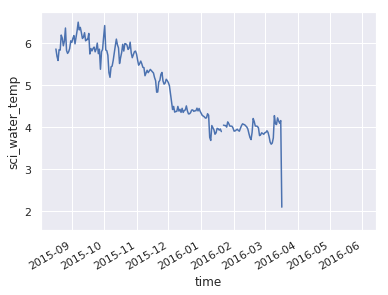

In [0]:
# Here's the Daily Average over all depths
ctd_data.sci_water_temp.load().resample(time='1D').mean().plot();

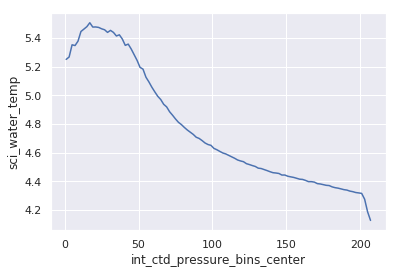

In [0]:
# Here's the Average Profile over all days
ctd_data.sci_water_temp.load().groupby_bins('int_ctd_pressure',np.arange(0, 210, 2)).mean().plot();

In [0]:
# Day and Depth Binning Function
def bindata(vd,binvar):
  bins = np.arange(0, 210, 2)
  labels = (bins[:-1] + bins[1:])/2
  a = vd.groupby_bins(binvar,bins,labels=labels).mean()
  return a

In [0]:
# Day & Depth Binning - Notice this is a 2-step process
data_bin = ctd_data.sel(time=slice('2015-08-17', '2016-03-01')).sci_water_temp.load().resample(time='1D').apply(bindata,binvar='int_ctd_pressure')


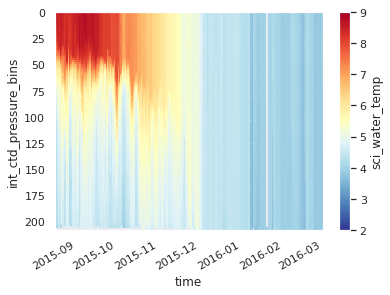

In [0]:
# Quick view of the results
data_bin.plot(x='time',y='int_ctd_pressure_bins',cmap='RdYlBu_r',vmin=2,vmax=9,yincrease=False);

In [0]:
# Convert to Dataframe
# This makes it easier to plot individual profiles
data_bin2 = data_bin.to_dataframe().reset_index()
data_bin2.head()

,time,int_ctd_pressure_bins,sci_water_temp
0,2015-08-17,1.0,8.576623
1,2015-08-17,3.0,8.599023
2,2015-08-17,5.0,8.601099
3,2015-08-17,7.0,8.595296
4,2015-08-17,9.0,8.588223


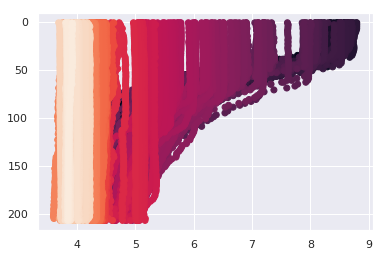

In [0]:
# Plot the profiles
plt.scatter(data_bin2.sci_water_temp, data_bin2.int_ctd_pressure_bins, c=data_bin2.time);
plt.gca().invert_yaxis();

## Altair Interactive Plotting Test
We will try to use the Altair plotting library (which is based on Vega and D3.js) to create an interactive plotting tool.  Altair requires the data to be in a pandas DataFrame.  For simplicity, we will also extract 1 profile per month, as that's all we want in the end.

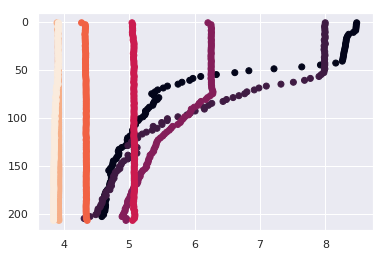

In [0]:
# Extract specific profiles
dates = pd.date_range('2015-08-01', periods=14, freq='MS')
data_bin2 = data_bin2[data_bin2.time.isin(dates)]
plt.scatter(data_bin2.sci_water_temp, data_bin2.int_ctd_pressure_bins, c=data_bin2.time);
plt.gca().invert_yaxis();

In [0]:
# We need to convert the time column to string to support inteactive selection
data_bin2['time2'] = data_bin2['time'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [0]:
# Interactive Altair plot
import altair as alt
input_dropdown = alt.binding_select(options=dates.format())
selection = alt.selection_single(fields=['time2'], bind=input_dropdown, name='Select a date ')

alt.Chart(data_bin2).mark_point().encode(
    alt.X('sci_water_temp:Q',
      scale=alt.Scale(zero=False)),
    alt.Y('int_ctd_pressure_bins:Q',
      scale=alt.Scale(domain=(220,0))),
    color='time:T'
).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

## A Better Processing Routine
Now let's try to develop the code to average muliple variables at once from different datasets.  However, we also want to do this 1 at a time for efficiency, as this process will fail if we try to load a large dataset, and even more so if we try to load multiple datasets (e.g. CTD, DO, and Chl).

In [0]:
import numpy as np
def reject_outliers(data, m=3):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
# First, we need to remove some outliers
ctd_data = ctd_data.where(ctd_data.int_ctd_pressure<250)
ctd_data = ctd_data.where(ctd_data.practical_salinity>0)

ctd_data['practical_salinity'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))
ctd_data['sci_oxy4_oxygen'] = ctd_data['sci_oxy4_oxygen'].where(reject_outliers(ctd_data['sci_oxy4_oxygen']))

flo_data = flo_data.where(flo_data.int_ctd_pressure<250)
flo_data['sci_flbbcd_chlor_units'] = flo_data['sci_flbbcd_chlor_units'].where(flo_data['sci_flbbcd_chlor_units']<5)

/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [0]:
# Now combine the datasets
var_list_do = ['int_ctd_pressure','sci_water_temp','practical_salinity','sci_oxy4_oxygen']
var_list_flo = ['int_ctd_pressure','sci_flbbcd_chlor_units']

ctd_data.reset_coords('int_ctd_pressure',inplace=True)
flo_data.reset_coords('int_ctd_pressure',inplace=True)

data = ctd_data[var_list_do].combine_first(flo_data[var_list_flo])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  """


In [0]:
# Specify dates to process
dates = pd.date_range('2015-09-01', periods=7, freq='MS')

# And now we do the depth binning for the selected dates
dsout = False
for d in dates:
  # print(d)
  ds = data.sel(time=slice(d,d+pd.Timedelta('1 day'))).load()
  if ds.sizes['time'] > 0:
    ds = ds.resample(time='1D').apply(bindata,binvar='int_ctd_pressure')
    if(isinstance(dsout,xr.Dataset)):
      dsout = xr.concat([dsout, ds],dim='time')
    else:
      dsout = ds

/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


In [0]:
# Convert to DataFrame for plotting
pldata = dsout.to_dataframe().reset_index()
# We need to convert the time column to string to support inteactive selection
pldata['time2'] = pldata['time'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [0]:
pldata.head()

,int_ctd_pressure_bins,time,int_ctd_pressure,sci_water_temp,practical_salinity,sci_oxy4_oxygen,sci_flbbcd_chlor_units,time2
0,1.0,2015-09-01,0.571746,8.477815,34.853173,278.670959,0.947130,2015-09-01
1,1.0,2015-10-01,0.663418,7.997213,34.832305,273.295746,1.182673,2015-10-01
2,1.0,2015-11-01,0.294139,6.251178,34.925051,276.726471,0.754497,2015-11-01
3,1.0,2015-12-01,0.702340,5.044254,34.942720,280.761108,0.255189,2015-12-01
4,1.0,2016-01-01,0.553358,4.309712,34.944581,279.406403,0.124582,2016-01-01


In [0]:
import altair as alt
input_dropdown = alt.binding_select(options=dates.format(), name='Select a date')
selection = alt.selection_single(fields=['time2'], bind=input_dropdown)

brush = alt.selection(type='interval')

base = alt.Chart(pldata).mark_line(point=True).encode(
    alt.Y('int_ctd_pressure_bins:Q', title='Depth (dbar)',
      scale=alt.Scale(domain=(220,0))),
    order=alt.Order("int_ctd_pressure_bins", sort="ascending"),
    color=alt.condition(brush, 
                        alt.Color('time:T', 
                                  scale=alt.Scale(scheme='redyellowblue', 
                                                  domain=(dates.format()[0],dates.format()[-1]) )), 
                        alt.ColorValue('gray')),
).transform_filter(
    selection
).properties(width=200)

p3 = alt.Chart(pldata).mark_point().encode(
    alt.Y('sci_water_temp:Q', title='Temperature (C)',
      scale=alt.Scale(domain=(3,9))),
    alt.X('practical_salinity:Q', title='Salinity (psu)',
      scale=alt.Scale(domain=(34.6,35.2))),
    color=alt.condition(brush, 'time:T', alt.ColorValue('gray')),
).transform_filter(
    selection
).properties(width=200,height=200)

alt.hconcat(
    base.encode(
        alt.X('sci_water_temp:Q', title='Temperature (C)',
              scale=alt.Scale(domain=(3,9))),
        ),
    base.encode(
        alt.X('practical_salinity:Q', title='Salinity (psu)',
              scale=alt.Scale(domain=(34.6,35.2))),
              ),
    p3
).add_selection(
    selection, brush
)

alt.HConcatChart(...)

## Variable Selection Test
Aparently, Altair does not currently allow you to change the plotted column once specified ([see this](https://github.com/altair-viz/altair/issues/1617)). One approach around this, is to flatten the dataset, and add a new colunn with the variable name.  So let's try that.

In [0]:
a = dsout['sci_water_temp'].to_dataframe().reset_index()
a.rename(columns={'sci_water_temp': 'data'}, inplace=True)
a['vari'] = 'temp'

b = dsout['practical_salinity'].to_dataframe().reset_index()
b.rename(columns={'practical_salinity': 'data'}, inplace=True)
b['vari'] = 'sal'

c = dsout['sci_oxy4_oxygen'].to_dataframe().reset_index()
c.rename(columns={'sci_oxy4_oxygen': 'data'}, inplace=True)
c['vari'] = 'do'

d = dsout['sci_flbbcd_chlor_units'].to_dataframe().reset_index()
d.rename(columns={'sci_flbbcd_chlor_units': 'data'}, inplace=True)
d['vari'] = 'chl'

a.head()

,time,int_ctd_pressure_bins,data,vari
0,2015-09-01,1.0,8.477815,temp
1,2015-09-01,3.0,8.472126,temp
2,2015-09-01,5.0,8.469436,temp
3,2015-09-01,7.0,8.466518,temp
4,2015-09-01,9.0,8.462281,temp


In [0]:
e = a.append(b).append(c).append(d)
e['time2'] = e['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
e.sample(10)

,time,int_ctd_pressure_bins,data,vari,time2
222,2015-11-01,29.0,276.185364,do,2015-11-01
381,2015-12-01,139.0,0.247358,chl,2015-12-01
358,2015-12-01,93.0,279.372070,do,2015-12-01
226,2015-11-01,37.0,0.825544,chl,2015-11-01
288,2015-11-01,161.0,5.169584,temp,2015-11-01
438,2016-01-01,45.0,34.960750,sal,2016-01-01
665,2016-03-01,83.0,34.933806,sal,2016-03-01
377,2015-12-01,131.0,0.253858,chl,2015-12-01
294,2015-11-01,173.0,5.070200,temp,2015-11-01
560,2016-02-01,81.0,0.100598,chl,2016-02-01


In [0]:
import altair as alt

dd = dates.format();
dd.append('null')

input_dropdown = alt.binding_select(options=dd, name='Select a date')
selection = alt.selection_single(fields=['time2'], bind=input_dropdown)

input_dropdown2 = alt.binding_select(options=['do','temp','chl','sal'], name='Select a variable')
selection2 = alt.selection_single(fields=['vari'], bind=input_dropdown2, init={'vari':'temp'}, on='none', clear='none')

alt.Chart(e).mark_line(point=True).encode(
    alt.X('data:Q', title='Temperature (C)',
      # scale=alt.Scale(domain=(3,9))
      ),
    alt.Y('int_ctd_pressure_bins:Q', title='Depth (dbar)',
      scale=alt.Scale(domain=(220,0))),
    order=alt.Order("int_ctd_pressure_bins", sort="ascending"),
    color=alt.Color('time:T', scale=alt.Scale(scheme='redyellowblue', domain=(dates.format()[0],dates.format()[-1]) )),                         
).transform_filter(
    selection
).transform_filter(
    selection2
).add_selection(
    selection,selection2
)

alt.Chart(...)

Unfortunately, while this works for one profile, there currently isn't a way to specify 2 pulldowns to update the 2 profile graphs and the 2 axes of the scatterplot.  In addion, there are still a few bugs with the graph initialization, dealing with "clear" state, and having the ability to plot all times at once.  So it looks like we will need to roll our own widget with D3.js.